## Fetal lung on pan-fetal immune

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import glob
import scanpy as sc 
import pandas as pd
import numpy as np
import milopy
import scipy
import anndata

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_context('talk')
from matplotlib.pyplot import rc_context

import milopy
import milopy.core as milo

In [3]:
# from oor_benchmark.metrics import auprc, FDR_TPR_FPR

In [4]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
library(tidyverse)

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [7]:
## Some utils

def _plot_nhood_sizes(adata, bins=50, **kwargs):
    plt.hist(np.array(adata.obsm['nhoods'].sum(0)).ravel(), bins=bins, **kwargs);
    plt.xlabel('# cells');plt.ylabel('# nhoods');
    
def get_nhood_adata(adata):
    return(adata.uns['nhood_adata'])

def get_cells_from_nhood(adata, i):
    return((adata.obsm['nhoods'][:,i].toarray() == 1).flatten())

def remove_x_axis(ax):
    ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_xlabel('');

def remove_y_axis(ax):
    ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_ylabel('');
    
def make_ct_label(label):
    return(' '.join(label.split('_')))

In [8]:
sns.color_palette('Paired')

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [9]:
## Define color palette
pal = sns.color_palette('Paired').as_hex()
design_palette = {'ACR':pal[3], 'CR':pal[7], 'AR':pal[9], 'joint_CR':pal[6]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

In [10]:
# figdir = '/home/jovyan/mount/gdrive/diff2atlas/figures/pbmc_design_comparison_Embedding_methods/'
# if not os.path.exists(figdir):
#     os.mkdir(figdir)

In [11]:
# %%R -i design_palette_df -i figdir
# design_palette = setNames(design_palette_df$color, rownames(design_palette_df))

## Prep atlas dataset 

Downloaded from [here](https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/PAN.A01.v01.raw_count.20210429.PFI.embedding.h5ad)

In [12]:
## Subsample by sample
np.random.seed(2345)

def _subsample(adata, sample_col, n_cells_sample = 1000):
    s_obs = pd.Series() 
    for s in adata.obs[sample_col].unique():
        s_obs_i = adata.obs_names[adata.obs[sample_col] == s]
        if s_obs_i.shape[0] > n_cells_sample:
            obs_df = adata.obs.loc[s_obs_i]
            obs_df[sample_col] = obs_df[sample_col].astype('str')
            s_obs_i = obs_df[[sample_col]].groupby(
                sample_col).sample(n_cells_sample).index
        s_obs = pd.concat([s_obs, pd.Series(s_obs_i)])
    s_obs = s_obs.values
    return(s_obs)

In [13]:
h5ad_file = '/nfs/team205/ed6/data/Fetal_immune/cellxgene_h5ad_files/scRNA_data/PAN.A01.v01.raw_count.20210429.PFI.embedding.h5ad'
adata_atlas = sc.read_h5ad(h5ad_file, backed=True)

In [14]:
## Remove low Q
lowQ_clusters = [
    "DOUBLET_IMMUNE_FIBROBLAST",
    "LOW_Q_INCONSISTENT",
    "DOUBLET_LYMPHOID_MACROPHAGE",
    "LOW_QUALITY",
    "HIGH_MITO",
    "DOUBLETS_FIBRO_ERY",
    "DOUBLET_ENDOTHELIUM_ERYTHROCYTE",
    "DOUBLET_ERY_B",
    "LOW_QUALITY_MACROPHAGE",
    "LOW_QUALITY_MID_ERY_(HIGH_RIBO)",
    "PLACENTAL_CONTAMINANTS",
    "DOUBLET",
    ]

keep_obs = adata_atlas.obs_names[
    (~adata_atlas.obs['organ'].isna()) & # remove maternal contaminants
    (~adata_atlas.obs['celltype_annotation'].isin(lowQ_clusters)) &  # remove low quality
    (adata_atlas.obs['age'] >= 14) # Filter by age
] 

keep_obs = _subsample(adata_atlas[keep_obs], sample_col='Sample', n_cells_sample=2000)

/tmp/ipykernel_15629/2809032511.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s_obs = pd.Series()


In [15]:
len(keep_obs)

191830

In [16]:
adata_atlas = adata_atlas[keep_obs].to_memory()

In [17]:
print('--- Atlas ---')
print('# donors:', adata_atlas.obs['donor'].nunique())
print('# samples:', adata_atlas.obs['Sample'].nunique())

--- Atlas ---
# donors: 11
# samples: 99


## Prep case-control dataset

Downloaded from [cellxgene](https://cellxgene.cziscience.com/collections/2d2e2acd-dade-489f-a2da-6c11aa654028)

In [18]:
h5ad_file = '/nfs/team205/ed6/data/He2020_fetal_lung.h5ad'
adata_query = sc.read_h5ad(h5ad_file, backed=True)

In [19]:
query_ages = ['18th week post-fertilization human stage', 
 '22nd week post-fertilization human stage', 
 '15th week post-fertilization human stage', 
 '20th week post-fertilization human stage', 
 ]

keep_obs = adata_query.obs_names[
    adata_query.obs['development_stage'].isin(query_ages)
]

keep_obs = _subsample(adata_query[keep_obs], sample_col='batch', n_cells_sample=1000)

/tmp/ipykernel_15629/2809032511.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s_obs = pd.Series()


In [20]:
adata_query = adata_query[keep_obs].to_memory()

In [21]:
print('--- Query ---')
print('# donors:', adata_query.obs['donor_id'].nunique())
print('# samples:', adata_query.obs['batch'].nunique())

--- Query ---
# donors: 8
# samples: 22


Uniform metadata

In [23]:
adata_query.obs['method'] = '5GEX'
adata_query.obs['Sample'] = adata_query.obs['batch'].copy()
adata_query.obs['donor'] = adata_query.obs['donor_id'].copy()

In [31]:
## Set ensemblIDs to var names
adata_atlas.var_names = adata_atlas.var['GeneID'].values

In [37]:
## Keep common vars
adata_query = adata_query[:, np.intersect1d(adata_query.var_names, adata_atlas.var_names)].copy()
adata_atlas = adata_atlas[:, np.intersect1d(adata_query.var_names, adata_atlas.var_names)].copy()

### Save for simulations

In [38]:
adata_atlas.write_h5ad('/lustre/scratch117/cellgen/team205/ed6/OOR_benchmark_fetal/PFI_atlas.subsampled.h5ad')
adata_query.write_h5ad('/lustre/scratch117/cellgen/team205/ed6/OOR_benchmark_fetal/FL_query.subsampled.h5ad')

### Select cell types for OOR simulation

In [41]:
adata_query.obs['sample_id'] = adata_query.obs['donor'].astype("str") + "_" + adata_query.obs['method'].astype('str')

In [51]:
adata_query.obs.columns

Index(['batch', 'dissection', 'chemistry', 'percent_mito', 'n_counts',
       'n_genes', 'doublet_scores', 'bh_pval', 'leiden', 'phase', 'S_score',
       'G2M_score', 'new_celltype', 'big_cluster', 'broad_celltype',
       'assay_ontology_term_id', 'cell_type_ontology_term_id',
       'development_stage_ontology_term_id', 'disease_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id', 'is_primary_data',
       'organism_ontology_term_id', 'sex_ontology_term_id',
       'tissue_ontology_term_id', 'donor_id', 'suspension_type', 'cell_type',
       'assay', 'disease', 'organism', 'sex', 'tissue',
       'self_reported_ethnicity', 'development_stage', 'method', 'Sample',
       'donor', 'sample_id'],
      dtype='object')

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


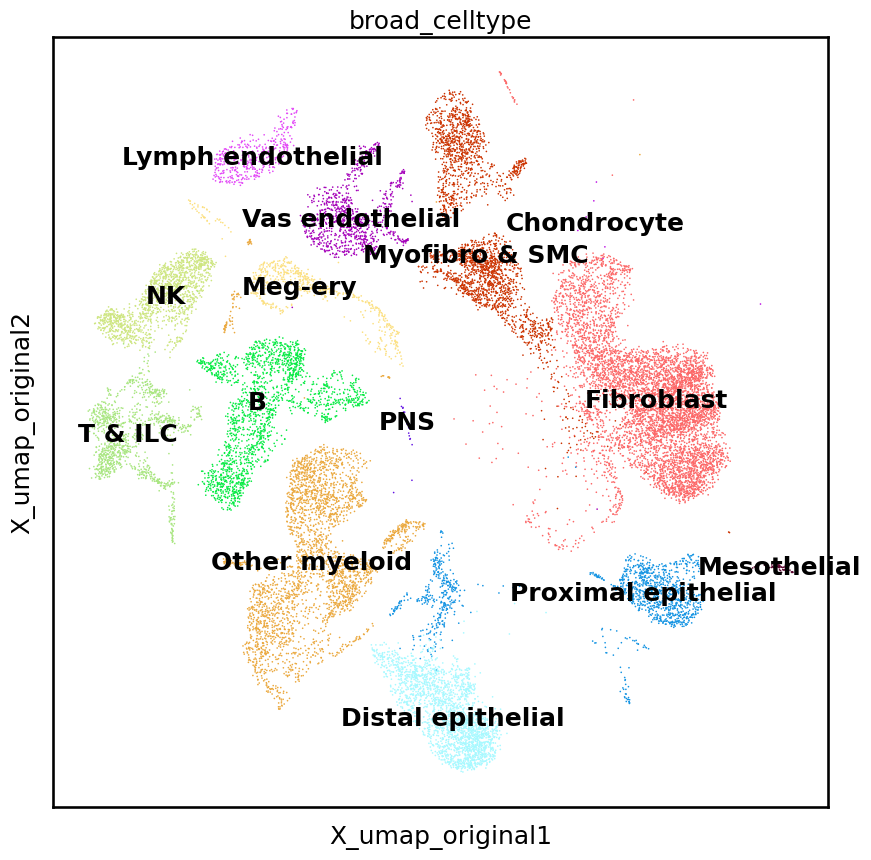

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


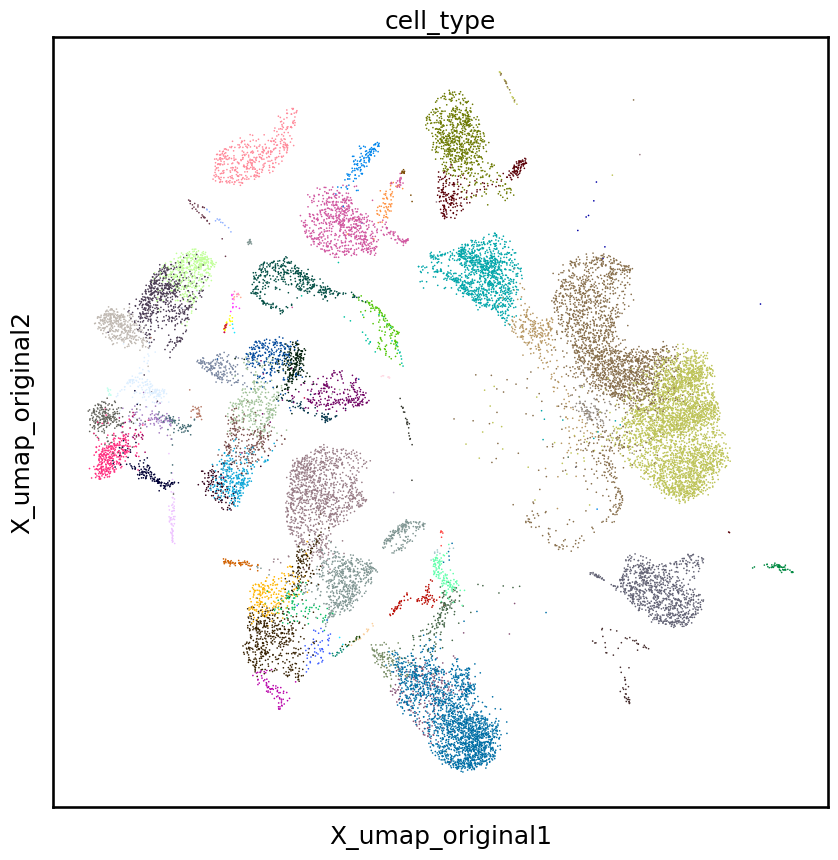

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


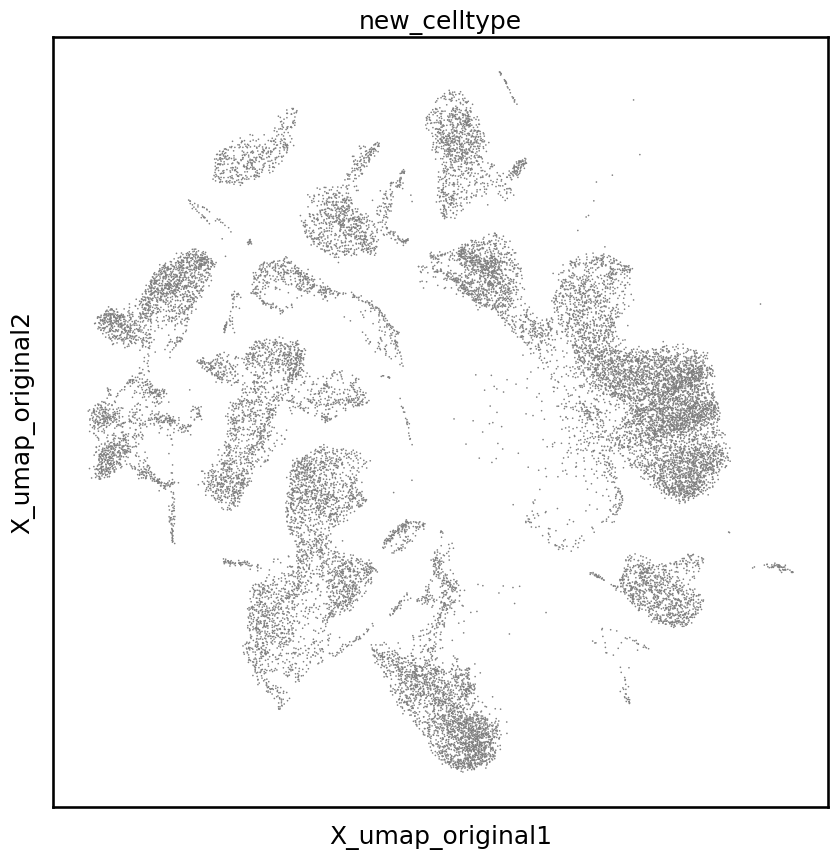

In [84]:
with plt.rc_context({'figure.figsize':[10,10]}):
    sc.pl.embedding(adata_query, 'X_umap_original', color='broad_celltype', legend_loc='on data')
    sc.pl.embedding(adata_query, 'X_umap_original', color='cell_type', legend_loc='none')
    sc.pl.embedding(adata_query, 'X_umap_original', color='new_celltype', legend_loc='none')

In [65]:
df = adata_query.obs.groupby(['broad_celltype', 'cell_type']).size().reset_index()
df = df[df[0] > 0]

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


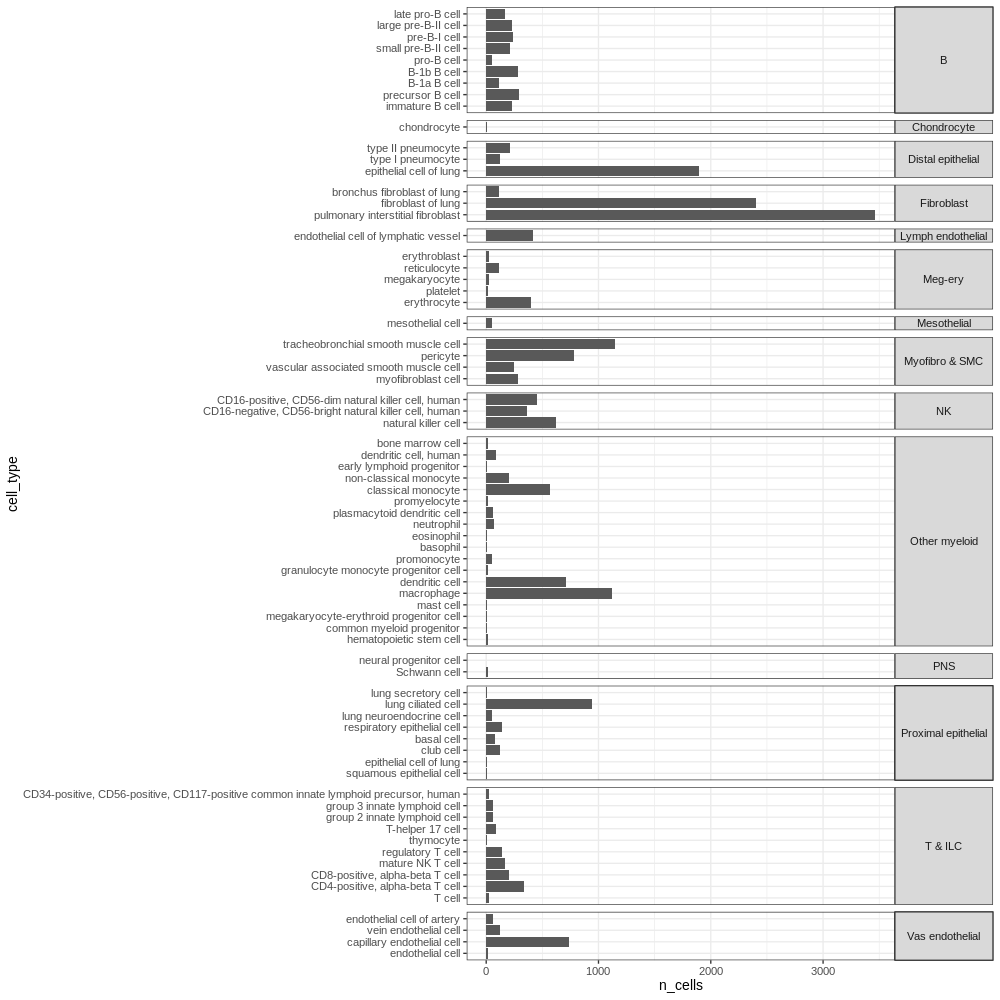

In [75]:
%%R -i df -h 1000 -w 1000
df %>%
mutate(n_cells = `0`) %>%
ggplot(aes(cell_type, n_cells)) +
geom_col() +
coord_flip() +
theme_bw(base_size=14) +
facet_grid(broad_celltype~., space='free', scales='free') +
theme(strip.text.y=element_text(angle=0))

In [87]:
df[df[0] > 300].sort_values(0)

,broad_celltype,cell_type,0
874,T & ILC,"CD4-positive, alpha-beta T cell",338
612,NK,"CD16-negative, CD56-bright natural killer cell...",366
367,Meg-ery,erythrocyte,398
341,Lymph endothelial,endothelial cell of lymphatic vessel,418
613,NK,"CD16-positive, CD56-dim natural killer cell, h...",452
678,Other myeloid,classical monocyte,568
589,NK,natural killer cell,622
655,Other myeloid,dendritic cell,707
981,Vas endothelial,capillary endothelial cell,737
522,Myofibro & SMC,pericyte,786


In [94]:
adata_query.obs['cell_type_clean'] = adata_query.obs['cell_type'].str.replace(" ", '_').str.replace("-", '_').str.replace(",", '')

immune_cts = ['natural_killer_cell', 'classical_monocyte', 'dendritic_cell']
stromal_cts = ['fibroblast_of_lung', 'pericyte', 'lung_ciliated_cell']

In [98]:
adata_query.obs['cell_type_clean'][adata_query.obs['cell_type_clean'].isin(immune_cts)].value_counts()

dendritic_cell         707
natural_killer_cell    622
classical_monocyte     568
Name: cell_type_clean, dtype: int64

In [99]:
adata_query.obs['cell_type_clean'][adata_query.obs['cell_type_clean'].isin(stromal_cts)].value_counts()

fibroblast_of_lung    2400
lung_ciliated_cell     941
pericyte               786
Name: cell_type_clean, dtype: int64

### Save datasets with OOR simulation

In [142]:
from oor_benchmark.datasets.simulation import simulate_query_reference
from oor_benchmark.api import check_dataset

In [143]:
split_seed = 2020
np.random.seed(split_seed)
all_samples = adata_query.obs['sample_id'].unique()
query_samples = np.random.choice(all_samples, size=int(len(all_samples)/2), replace=False)
ctrl_samples = all_samples[~all_samples.isin(query_samples)]

In [144]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/OOR_benchmark_fetal/'

In [ ]:
adata_query = adata_query.raw.to_adata()

In [148]:
outdir

'/lustre/scratch117/cellgen/team205/ed6/OOR_benchmark_fetal/'

In [147]:
annotation_col = 'cell_type_clean'

for ct in immune_cts + stromal_cts:
    print(ct)
    adata = simulate_query_reference(
        adata_query, query_annotation=[ct],
        annotation_col=annotation_col, 
        batch_col='sample_id',
        query_batch = query_samples.tolist(),
        ctrl_batch = ctrl_samples.tolist(),
    )

    # Save intermediate files
    sim_id = f"He2022_lung_{annotation_col}{ct}_seed{split_seed}/"
    if not os.path.exists(outdir + sim_id):
        os.mkdir(outdir + sim_id)

    # Run embedding and differential abundance testing
    if 'X_scVI' in adata.obsm:
        del adata.obsm['X_scVI']
        
    assert check_dataset(adata)
    adata.write_h5ad(outdir + sim_id + 'query_ctrl_adata.h5ad')

natural_killer_cell
classical_monocyte
dendritic_cell
fibroblast_of_lung
pericyte
lung_ciliated_cell


In [153]:
h5ad_path = outdir + sim_id + 'query_ctrl_adata.h5ad'
'/'.join(h5ad_path.split('/')[:-1])

'/lustre/scratch117/cellgen/team205/ed6/OOR_benchmark_fetal/He2022_lung_cell_type_cleanlung_ciliated_cell_seed2020'